# AutoGluon Time Series - Forecasting

In [1]:
import pandas as pd
from autogluon.timeseries import TimeSeriesDataFrame, TimeSeriesPredictor

/Users/caiosainvallio/miniconda3/envs/ag/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Loading time series data as a TimeSeriesDataFrame

In [2]:
df = pd.read_csv("https://autogluon.s3.amazonaws.com/datasets/timeseries/m4_hourly_subset/train.csv")
df.head()

,item_id,timestamp,target
0,H1,1750-01-01 00:00:00,605.0
1,H1,1750-01-01 01:00:00,586.0
2,H1,1750-01-01 02:00:00,586.0
3,H1,1750-01-01 03:00:00,559.0
4,H1,1750-01-01 04:00:00,511.0


In [3]:
train_data = TimeSeriesDataFrame.from_data_frame(
    df,
    id_column="item_id",
    timestamp_column="timestamp"
)
train_data.head()

target
item_id timestamp                  
H1      1750-01-01 00:00:00   605.0
        1750-01-01 01:00:00   586.0
        1750-01-01 02:00:00   586.0
        1750-01-01 03:00:00   559.0
        1750-01-01 04:00:00   511.0

## Training time series models with TimeSeriesPredictor.fit

In [4]:
predictor = TimeSeriesPredictor(
    prediction_length=48,
    path="autogluon-m4-hourly",
    target="target",
    eval_metric="MASE",
)

predictor.fit(
    train_data,
    presets="medium_quality",
    time_limit=600,
)

Beginning AutoGluon training... Time limit = 600s
AutoGluon will save models to 'autogluon-m4-hourly'
=================== System Info ===================
AutoGluon Version:  1.0.0
Python Version:     3.10.13
Operating System:   Darwin
Platform Machine:   arm64
Platform Version:   Darwin Kernel Version 23.2.0: Wed Nov 15 21:54:05 PST 2023; root:xnu-10002.61.3~2/RELEASE_ARM64_T6031
CPU Count:          16
GPU Count:          0
Memory Avail:       24.68 GB / 48.00 GB (51.4%)
Disk Space Avail:   704.09 GB / 926.35 GB (76.0%)
Setting presets to: medium_quality

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': MASE,
 'hyperparameters': 'light',
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 48,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'target': 'target',
 'time_limit': 600,
 'verbosity': 2}

Inferred time series frequency: 'H'
Provided train_data has

## Generating forecasts with TimeSeriesPredictor.predict

In [5]:
predictions = predictor.predict(train_data)
predictions.head()

Model not specified in predict, will default to the model with the best validation score: WeightedEnsemble


mean         0.1         0.2         0.3  \
item_id timestamp                                                             
H1      1750-01-30 04:00:00  628.266367  608.160742  615.062590  620.039308   
        1750-01-30 05:00:00  558.064668  531.817389  540.827541  547.324495   
        1750-01-30 06:00:00  515.703113  484.740065  495.369043  503.033285   
        1750-01-30 07:00:00  484.100765  449.160071  461.154494  469.803316   
        1750-01-30 08:00:00  460.626424  422.179810  435.377743  444.894381   

                                    0.4         0.5         0.6         0.7  \
item_id timestamp                                                             
H1      1750-01-30 04:00:00  624.291730  628.266367  632.241003  636.493425   
        1750-01-30 05:00:00  552.875902  558.064668  563.253435  568.804842   
        1750-01-30 06:00:00  509.582096  515.703113  521.824130  528.372942   
        1750-01-30 07:00:00  477.193416  484.100765  491.008113  498.398213   
        1750-01-30 08:00:00  453.025997  460.626424  468.226850  476.358466   

                                    0.8         0.9  
item_id timestamp                                    
H1      1750-01-30 04:00:00  641.470143  648.371991  
        1750-01-30 05:00:00  575.301796  584.311947  
        1750-01-30 06:00:00  536.037183  546.666162  
        1750-01-30 07:00:00  507.047036  519.041458  
        1750-01-30 08:00:00  485.875104  499.073037

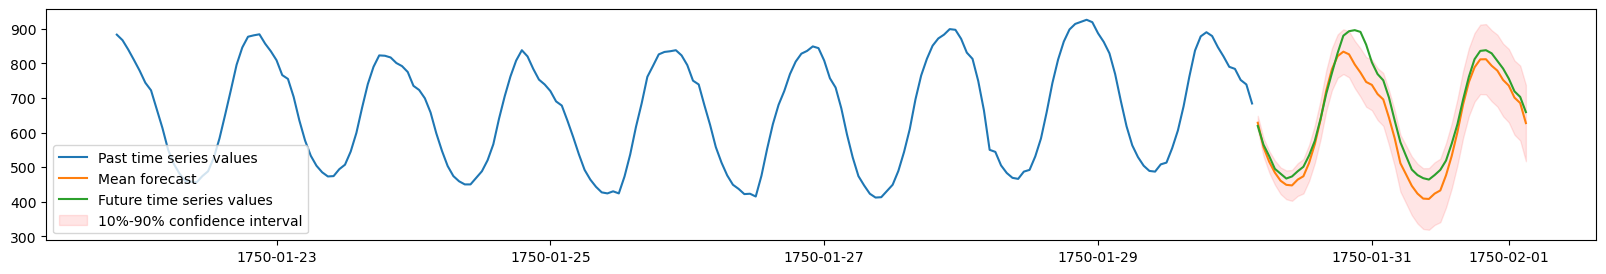

In [6]:
import matplotlib.pyplot as plt

# TimeSeriesDataFrame can also be loaded directly from a file
test_data = TimeSeriesDataFrame.from_path("https://autogluon.s3.amazonaws.com/datasets/timeseries/m4_hourly_subset/test.csv")

plt.figure(figsize=(20, 3))

item_id = "H1"
y_past = train_data.loc[item_id]["target"]
y_pred = predictions.loc[item_id]
y_test = test_data.loc[item_id]["target"][-48:]

plt.plot(y_past[-200:], label="Past time series values")
plt.plot(y_pred["mean"], label="Mean forecast")
plt.plot(y_test, label="Future time series values")

plt.fill_between(
    y_pred.index, y_pred["0.1"], y_pred["0.9"], color="red", alpha=0.1, label=f"10%-90% confidence interval"
)
plt.legend();

## Evaluating the performance of different models

In [7]:
# The test score is computed using the last
# prediction_length=48 timesteps of each time series in test_data
predictor.leaderboard(test_data)

Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).


,model,score_test,score_val,pred_time_test,pred_time_val,fit_time_marginal,fit_order
0,WeightedEnsemble,-0.855041,-0.914341,20.072935,22.112701,1.224453,8
1,RecursiveTabular,-0.862797,-0.933874,0.695010,0.890931,13.561925,5
2,SeasonalNaive,-1.022854,-1.216909,0.921812,0.072752,0.044929,2
3,DirectTabular,-1.683834,-1.370318,0.199800,0.172586,6.928918,6
4,ETS,-1.805637,-1.968375,18.252532,20.976432,0.046350,3
5,Theta,-1.905365,-2.142531,4.813877,5.195029,0.047134,4
6,TemporalFusionTransformer,-2.116844,-2.180516,0.377387,0.306158,248.694289,7
7,Naive,-6.696079,-6.662942,0.075961,0.901392,0.053427,1
